In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle_v11 as dnw
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

import networkx as nx

/tmp/ipykernel_3553741/3813874115.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
idnet_path = '/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [3]:
usdm_d1 = dnet.DroughtNetwork.unpickle(f'{idnet_path}/USDM_net_fwa_d1_rt20p.pickle')

usdm_d1.create_animated_gif(out_path='/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/animations/usdm_d1_conus105w.gif',fps=8)

In [4]:
spi30d_d1 = dnet.DroughtNetwork.unpickle(f'{idnet_path}/spi_30d_net_fwa_d1_rt20p.pickle')

In [5]:
spi180d_d1 = dnet.DroughtNetwork.unpickle(f'{idnet_path}/spi_180d_net_fwa_d1_rt20p.pickle')

spi30d_d1.create_animated_gif(out_path='/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/animations/spi30d_d1_conus105w.gif',fps=8)

spi180d_d1.create_animated_gif(out_path='/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/animations/spi180d_d1_conus105w.gif',fps=8)

Those look good, but now I need to plot the centroids on top of them.

In [6]:
dt_path = '/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/drought_tracks'

In [7]:
exp_tag = 'fwa_d1_rt20p'

In [8]:
usdm_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/USDM_tracks_{exp_tag}.pickle')

In [9]:
spi30d_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/spi_30d_tracks_{exp_tag}.pickle')

In [10]:
spi180d_dtd = dnw.convert_pickle_to_dtd(f'{dt_path}/spi_180d_tracks_{exp_tag}.pickle')

I need to first get the tracks into cartesian time, as opposed to lagrangian

In [11]:
x_tracks = usdm_dtd['x']
y_tracks = usdm_dtd['y']
t_tracks = usdm_dtd['t']

In [12]:
x_cart = []
y_cart = []
t_cart = []
lon_cart = []
lat_cart = []

for i in np.arange(np.max(np.hstack(t_tracks))+1):
    x_cart.append(list())
    y_cart.append(list())
    t_cart.append(list())
    lon_cart.append(list())
    lat_cart.append(list())

In [13]:
for x_track, y_track, t_track in zip(x_tracks, y_tracks, t_tracks):
    for x, y, t in zip(x_track, y_track, t_track):
        
        x_cart[t].append(x)
        y_cart[t].append(y)
        t_cart[t].append(t)
        

In [14]:
for i, (x_track, y_track) in tqdm(enumerate(zip(x_cart, y_cart)), total=len(x_cart)):
    lon, lat = dnw.transform_points(x_track, y_track)
    lon_cart[i] = lon
    lat_cart[i] = lat

  0%|          | 0/1162 [00:00<?, ?it/s]

In [15]:
usdm_array = usdm_d1.to_array()

KeyboardInterrupt: 

In [16]:
usdm_ds = xr.open_dataset('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/usdm/USDM_CONUS_105W_20000104_20220412.nc')

In [17]:
usdm_ds

<xarray.Dataset>
Dimensions:      (x: 897, y: 1214, time: 1163)
Coordinates:
  * x            (x) float64 -2.955e+06 -2.952e+06 ... -6.62e+05 -6.595e+05
  * y            (y) float64 3.281e+06 3.279e+06 ... 1.764e+05 1.739e+05
  * time         (time) datetime64[ns] 2000-01-04 2000-01-11 ... 2022-04-12
Data variables:
    spatial_ref  int64 ...
    USDM         (time, y, x) float64 ...
Attributes:
    compilation:  a. stein, 1/18/2023
    description:  weekly gridded United States Drought Monitor (USDM) from 1/...
    source:       https://www1.ncdc.noaa.gov/pub/data/nidis/geojson/us/usdm-t...
    crs:          EPSG:5070
    join:         lat, lon taken from 2000-01-04 file
    clipping:     original data was clipped to CONUS using http://eric.clst.o...

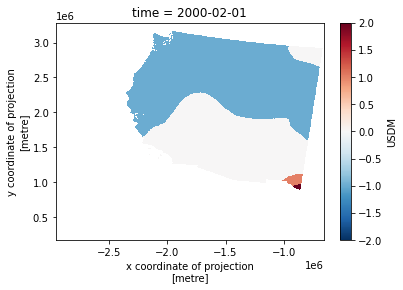

In [23]:
usdm_ds['USDM'].isel(time=4).plot()

In [ ]:
x_usdm = usdm_ds.x.values
y_usdm = usdm_ds.y.values

In [ ]:
usdm_dnet_da = xr.DataArray(
    data=usdm_array,
    dims=['time', 'y', 'x'],
    coords = dict(
        x=x_usdm,
        y=y_usdm,
        time=np.arange(usdm_array.shape[0])
    )
)

import rioxarray

usdm_dnet_da_4326 = usdm_dnet_da.rio.write_crs('EPSG:5070').rio.reproject('EPSG:4326')

In [22]:
usdm_dnet_da.shape

(1159, 1214, 897)

In [23]:
usdm_array.shape

(1159, 1214, 897)

In [24]:
len(x_cart)

1162

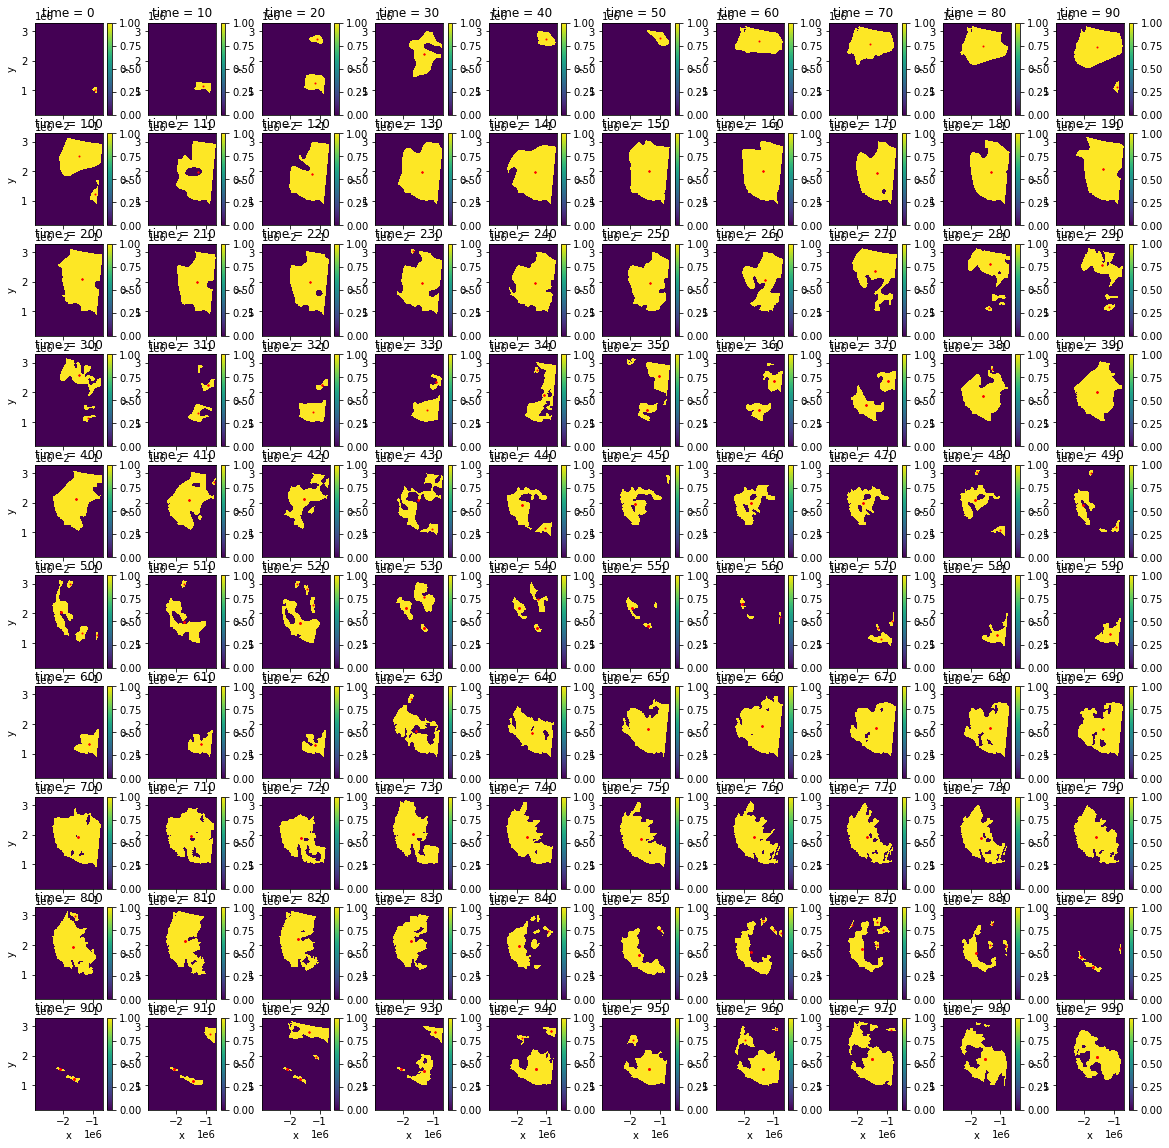

In [28]:
fig, axs = plt.subplots(10, 10, figsize=(20,20))

for i, ax in enumerate(axs.ravel()):
    usdm_dnet_da.isel(time=10*i).plot(ax=ax)
    ax.scatter(x_cart[10*i+4], y_cart[10*i+4], s=1, color='r')
    ax.set_aspect('equal')

In [48]:
spi30d_array = spi30d_d1.to_array()

In [51]:
spi30d_ds = xr.open_dataset('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/spi/CONUS_105W/spi_30d.nc')

In [53]:
spi30d_dnet_da = xr.DataArray(
    data=spi30d_array,
    dims=['time', 'y', 'x'],
    coords = dict(
        x=spi30d_ds.x.values,
        y=spi30d_ds.y.values,
        time=np.arange(spi30d_array.shape[0])
    )
)

In [56]:
x_cart = []
y_cart = []
t_cart = []

for i in np.arange(np.max(np.hstack(spi30d_dtd['t']))+1):
    x_cart.append(list())
    y_cart.append(list())
    t_cart.append(list())

In [57]:
for x_track, y_track, t_track in zip(spi30d_dtd['x'], spi30d_dtd['y'], spi30d_dtd['t']):
    for x, y, t in zip(x_track, y_track, t_track):
        
        x_cart[t].append(x)
        y_cart[t].append(y)
        t_cart[t].append(t)        

In [59]:
spi30d_ds

<xarray.Dataset>
Dimensions:  (x: 525, y: 702, time: 3066)
Coordinates:
  * x        (x) float64 -2.893e+06 -2.889e+06 ... -6.674e+05 -6.632e+05
  * y        (y) float64 3.251e+06 3.246e+06 3.242e+06 ... 2.717e+05 2.674e+05
  * time     (time) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
Data variables:
    crs      int64 ...
    spi      (time, y, x) float32 ...

In [61]:
len(x_cart)

3065

In [64]:
t_cart

[[0],
 [1, 1, 1, 1],
 [2, 2, 2, 2],
 [3, 3, 3, 3],
 [4, 4, 4, 4],
 [5, 5, 5, 5],
 [6, 6, 6, 6],
 [7, 7, 7, 7],
 [8, 8, 8, 8],
 [9, 9, 9, 9],
 [10, 10, 10, 10, 10],
 [11, 11, 11, 11, 11, 11, 11, 11],
 [12, 12, 12, 12, 12, 12, 12, 12],
 [13, 13, 13, 13, 13, 13, 13, 13],
 [],
 [],
 [],
 [17, 17],
 [18],
 [],
 [20],
 [],
 [],
 [23],
 [24, 24, 24],
 [25, 25, 25, 25],
 [26, 26, 26, 26, 26],
 [27, 27, 27, 27, 27],
 [28, 28, 28, 28, 28],
 [29, 29, 29, 29, 29],
 [30, 30, 30, 30, 30],
 [31, 31, 31, 31, 31],
 [32, 32, 32, 32, 32],
 [33, 33, 33, 33, 33],
 [34, 34, 34, 34, 34],
 [35, 35, 35, 35, 35, 35],
 [36, 36, 36, 36, 36, 36, 36],
 [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37],
 [38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38],
 [39, 39, 39, 39, 39, 39],
 [40, 40, 40, 40, 40, 40],
 [41, 41, 41, 41, 41, 41],
 [42, 42, 42, 42, 42, 42],
 [43, 43, 43, 43, 43, 43],
 [44, 44, 44, 44, 44, 44],
 [45, 45, 45, 45, 45, 45, 45],
 [46, 46, 46, 46, 46, 46, 46, 46],
 [47, 47, 47, 47],
 [48, 48, 48, 48],
 [

In [68]:
np.max(np.hstack(t_cart))

3064.0

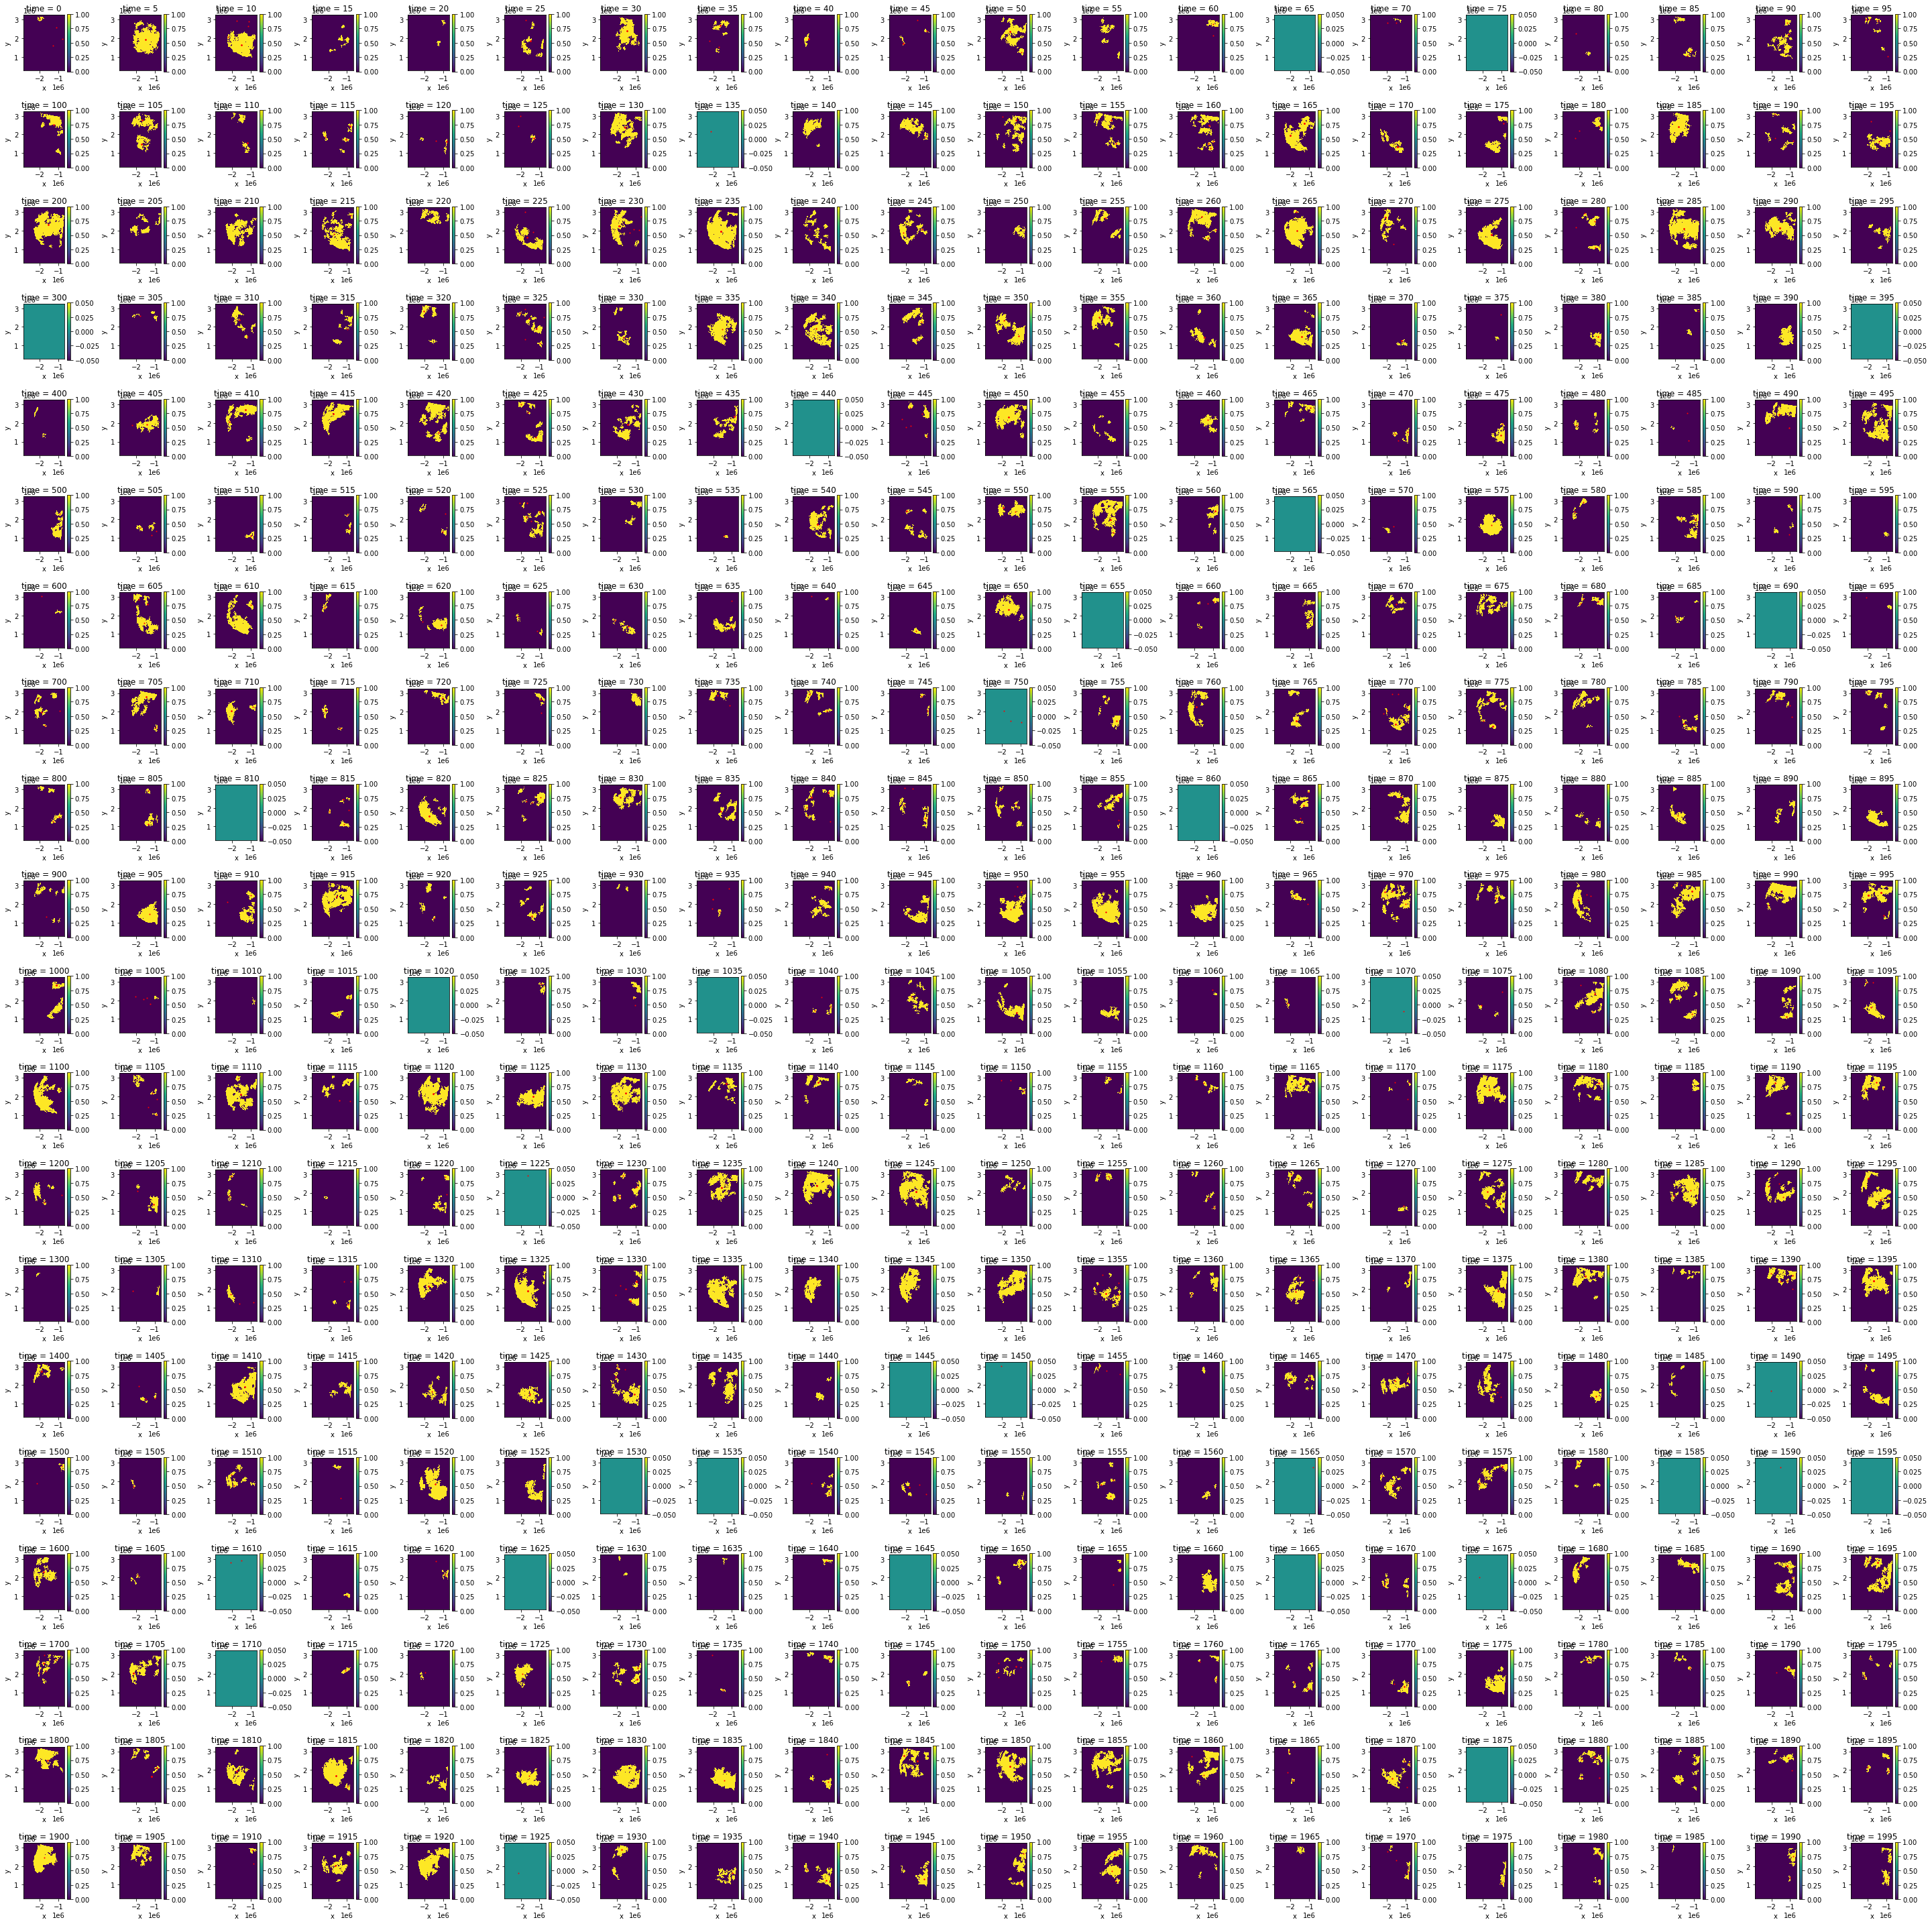

In [70]:
fig, axs = plt.subplots(20, 20, figsize=(40,40))

for i, ax in enumerate(axs.ravel()):
    spi30d_dnet_da.isel(time=5*i).plot(ax=ax)
    ax.scatter(x_cart[5*i], y_cart[5*i], s=1, color='r')
    ax.set_aspect('equal')

plt.tight_layout()

In [50]:
spi180d_array = spi180d_d1.to_array()

In [52]:
spi180d_ds = xr.open_dataset('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/spi/CONUS_105W/spi_180d.nc')

In [55]:
spi180d_dnet_da = xr.DataArray(
    data=spi180d_array,
    dims=['time', 'y', 'x'],
    coords = dict(
        x=spi180d_ds.x.values,
        y=spi180d_ds.y.values,
        time=np.arange(spi180d_array.shape[0])
    )
)

In [71]:
x_cart = []
y_cart = []
t_cart = []

for i in np.arange(np.max(np.hstack(spi30d_dtd['t']))+1):
    x_cart.append(list())
    y_cart.append(list())
    t_cart.append(list())

In [72]:
for x_track, y_track, t_track in zip(spi180d_dtd['x'], spi180d_dtd['y'], spi180d_dtd['t']):
    for x, y, t in zip(x_track, y_track, t_track):
        
        x_cart[t].append(x)
        y_cart[t].append(y)
        t_cart[t].append(t)        

In [73]:
spi180d_ds

<xarray.Dataset>
Dimensions:  (x: 525, y: 702, time: 3066)
Coordinates:
  * x        (x) float64 -2.893e+06 -2.889e+06 ... -6.674e+05 -6.632e+05
  * y        (y) float64 3.251e+06 3.246e+06 3.242e+06 ... 2.717e+05 2.674e+05
  * time     (time) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-12-31
Data variables:
    crs      int64 ...
    spi      (time, y, x) float32 ...

In [74]:
len(x_cart)

3065

In [75]:
t_cart

[[],
 [1, 1],
 [2, 2, 2],
 [3, 3],
 [4, 4, 4],
 [5, 5, 5],
 [6, 6, 6, 6, 6],
 [7, 7],
 [8, 8, 8],
 [9, 9, 9],
 [10, 10, 10],
 [11, 11, 11, 11],
 [12, 12, 12, 12, 12, 12],
 [13, 13, 13, 13, 13, 13, 13, 13],
 [14, 14, 14, 14, 14, 14, 14],
 [15, 15, 15, 15, 15, 15, 15],
 [16, 16, 16, 16, 16, 16, 16, 16],
 [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
 [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
 [19, 19, 19, 19, 19, 19, 19, 19],
 [20, 20, 20, 20, 20, 20, 20],
 [21, 21, 21, 21, 21, 21, 21, 21],
 [22, 22, 22, 22, 22, 22, 22, 22, 22],
 [23, 23, 23, 23, 23, 23, 23, 23, 23],
 [24, 24, 24, 24, 24, 24, 24, 24, 24],
 [25, 25, 25, 25, 25, 25, 25, 25, 25],
 [26, 26, 26, 26, 26, 26, 26, 26, 26, 26],
 [27, 27, 27, 27, 27, 27, 27, 27, 27, 27],
 [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28],
 [29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29],
 [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
 [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
 [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
 [33, 33, 33, 33, 33, 33, 33,

In [76]:
np.max(np.hstack(t_cart))

3064.0

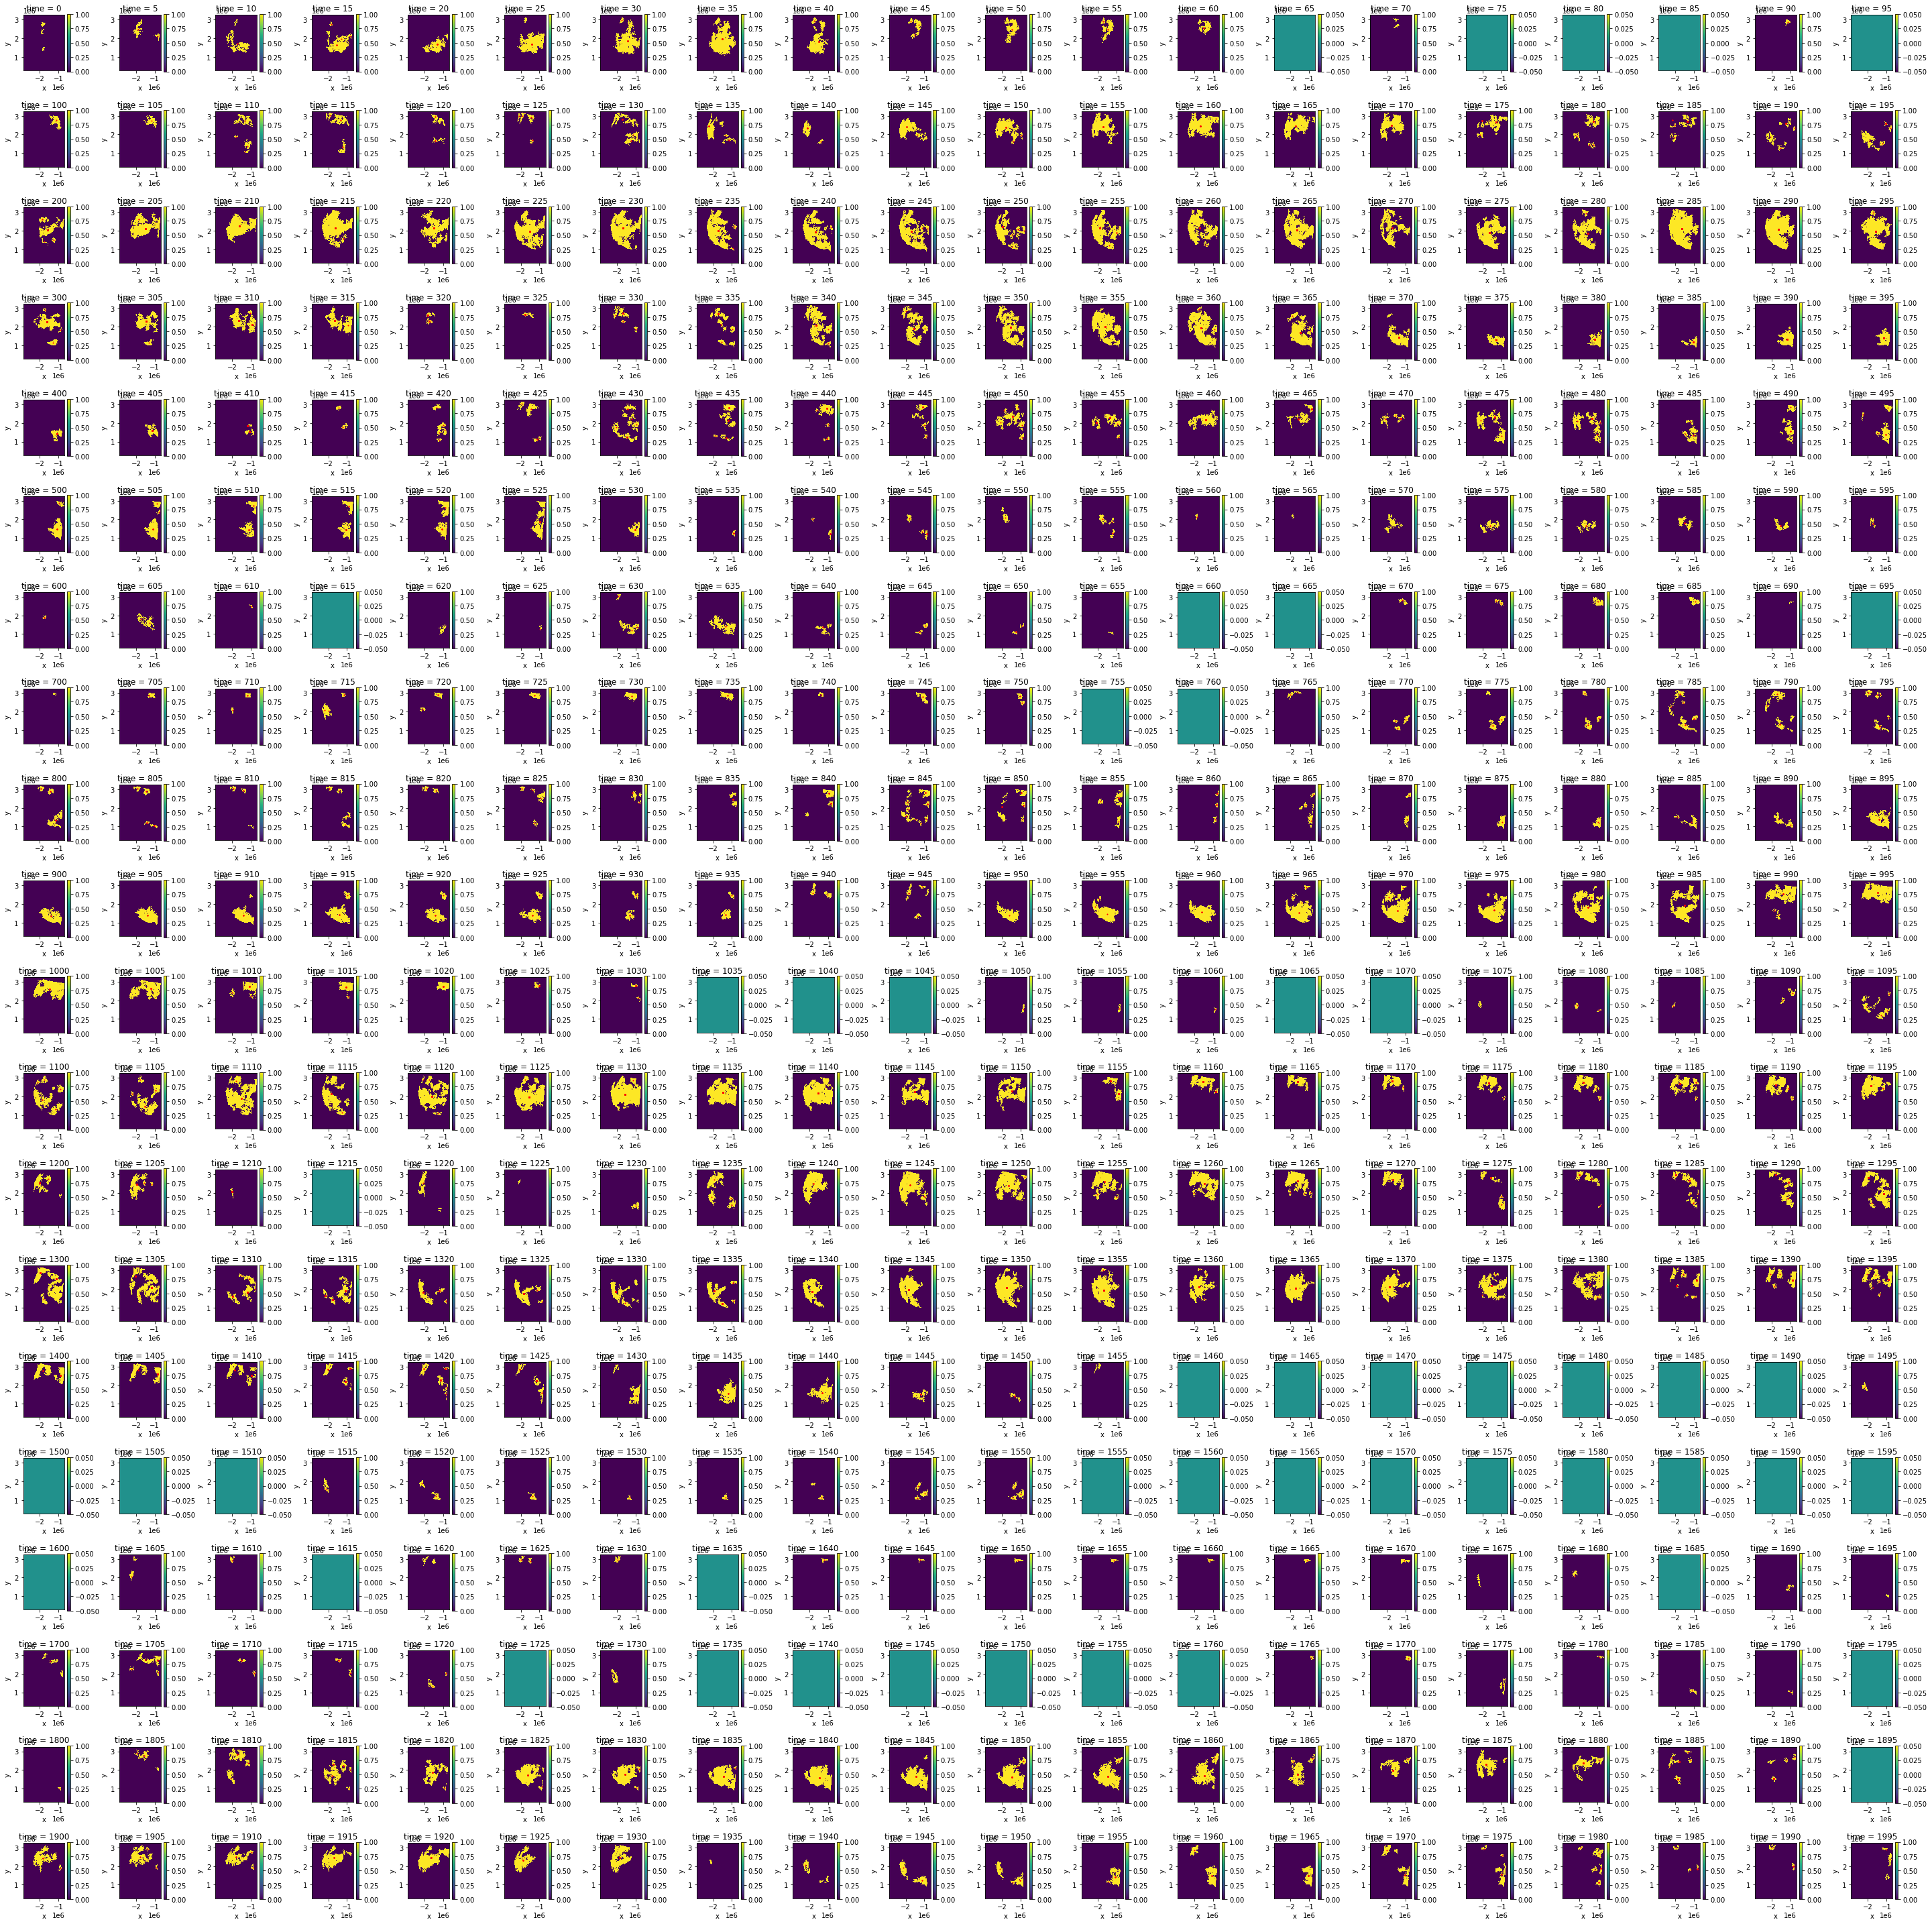

In [77]:
fig, axs = plt.subplots(20, 20, figsize=(40,40))

for i, ax in enumerate(axs.ravel()):
    spi180d_dnet_da.isel(time=5*i).plot(ax=ax)
    ax.scatter(x_cart[5*i], y_cart[5*i], s=1, color='r')
    ax.set_aspect('equal')

plt.tight_layout()

fig, ax = plt.subplots()

x_flat = np.hstack(x_tracks)
x_min = np.min(x_flat)
x_max = np.max(x_flat)
y_flat = np.hstack(y_tracks)
y_min = np.min(y_flat)
y_max = np.max(y_flat)


frames = len(x_cart)
times = np.arange(frames)
fps=8

out_path = 'centroid_scatter_wdnet_test.gif'

def plot_overlap(i):
    ax.pcolormesh(usdm_dnet_da.isel(time=i))
    ax.scatter(x_cart[i], y_cart[i])
    return ax

def animate(i):
    ax.clear()
    ax.invert_yaxis()
    #ax.set_xlim(x_min, x_max)
    #ax.set_ylim(y_min, y_max)
    ax.set_title(times[i])
    return (plot_overlap(i),)

ani = mpl.animation.FuncAnimation(fig, animate, frames=frames, blit=True)
writer = mpl.animation.ImageMagickWriter(fps=fps)

ani.save(out_path, writer=writer)

Okay, so how I'm reading these plots is making sense.

In [2]:
usdm_d2 = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/USDM_net_fe2_d2_rt20p.pickle')

In [3]:
spi30d_d2 = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/spi_30d_net_fe2_d2_rt20p.pickle')

In [4]:
spi180d_d2 = dnet.DroughtNetwork.unpickle('/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet/spi_180d_net_fe2_d2_rt20p.pickle')

In [7]:
usdm_d2.create_animated_gif(out_path='/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/animations/usdm_d2_conus105w.gif',fps=8)

Exception: File already exists. Please delete or enable overwrite.

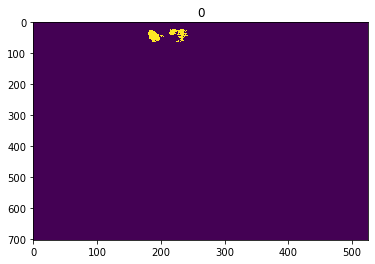

In [5]:
spi30d_d2.create_animated_gif(out_path='/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/animations/spi30d_d2_conus105w.gif',fps=8)

In [6]:
spi180d_d2.create_animated_gif(out_path='/pool0/home/steinjao/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/animations/spi180d_d2_conus105w.gif',fps=8)